# Analyse de l'incidence du syndrome grippal

Dans un premier temps nous allons inspecter les données et dans un deuxième temps nous allons les analyser et en traire une conclusion. 
**Remember the first step is to take a manual look at all the data all together!!**

In [1]:
#Importation des bibliothèques principales
 #Demander à python de garder les fichier inside the document and not on outside widows.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

In [2]:
data_url= "https://www.sentiweb.fr/datasets/incidence-PAY-3.csv"
raw_data = pd.read_csv(data_url, skiprows=1) #Otherwise unable to read the first raw which is messy
raw_data

week  indicator     inc   inc_low    inc_up  inc100  inc100_low  \
0     202011          3  101704   93652.0  109756.0     154       142.0   
1     202010          3  104977   96650.0  113304.0     159       146.0   
2     202009          3  110696  102066.0  119326.0     168       155.0   
3     202008          3  143753  133984.0  153522.0     218       203.0   
4     202007          3  183610  172812.0  194408.0     279       263.0   
...      ...        ...     ...       ...       ...     ...         ...   
1841  198448          3   78620   60634.0   96606.0     143       110.0   
1842  198447          3   72029   54274.0   89784.0     131        99.0   
1843  198446          3   87330   67686.0  106974.0     159       123.0   
1844  198445          3  135223  101414.0  169032.0     246       184.0   
1845  198444          3   68422   20056.0  116788.0     125        37.0   

      inc100_up geo_insee geo_name  
0         166.0        FR   France  
1         172.0        FR   France  
2         181.0        FR   France  
3         233.0        FR   France  
4         295.0        FR   France  
...         ...       ...      ...  
1841      176.0        FR   France  
1842      163.0        FR   France  
1843      195.0        FR   France  
1844      308.0        FR   France  
1845      213.0        FR   France  

[1846 rows x 10 columns]

## Missing data wrangling
Now that we have seen a line with missing data we are going to supress it well8

In [3]:
#raw_data[raw_data.dropna().copy()]
data = raw_data.dropna().copy()
data

week  indicator     inc   inc_low    inc_up  inc100  inc100_low  \
0     202011          3  101704   93652.0  109756.0     154       142.0   
1     202010          3  104977   96650.0  113304.0     159       146.0   
2     202009          3  110696  102066.0  119326.0     168       155.0   
3     202008          3  143753  133984.0  153522.0     218       203.0   
4     202007          3  183610  172812.0  194408.0     279       263.0   
...      ...        ...     ...       ...       ...     ...         ...   
1841  198448          3   78620   60634.0   96606.0     143       110.0   
1842  198447          3   72029   54274.0   89784.0     131        99.0   
1843  198446          3   87330   67686.0  106974.0     159       123.0   
1844  198445          3  135223  101414.0  169032.0     246       184.0   
1845  198444          3   68422   20056.0  116788.0     125        37.0   

      inc100_up geo_insee geo_name  
0         166.0        FR   France  
1         172.0        FR   France  
2         181.0        FR   France  
3         233.0        FR   France  
4         295.0        FR   France  
...         ...       ...      ...  
1841      176.0        FR   France  
1842      163.0        FR   France  
1843      195.0        FR   France  
1844      308.0        FR   France  
1845      213.0        FR   France  

[1845 rows x 10 columns]

 Nos données utilisent une convention inhabituelle: le numéro de
semaine est collé à l'année, donnant l'impression qu'il s'agit
de nombre entier. C'est comme ça que Pandas les interprète.Un deuxième problème est que Pandas ne comprend pas les numéros de
semaine.  Il faut lui fournir les dates de début et de fin de
semaine. Nous utilisons pour cela la bibliothèque isoweek.Comme la conversion des semaines est devenu assez complexe, nous
écrivons une petite fonction Python pour cela. Ensuite, nous
l'appliquons à tous les points de nos donnés. Les résultats vont
dans une nouvelle colonne 'period'.

In [4]:
def convert_week(year_week_int):
    year_week_str= str(year_week_int)
    year = int(year_week_str[:4])
    week = int(year_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]
data['period']

0       2020-03-09/2020-03-15
1       2020-03-02/2020-03-08
2       2020-02-24/2020-03-01
3       2020-02-17/2020-02-23
4       2020-02-10/2020-02-16
                ...          
1841    1984-11-26/1984-12-02
1842    1984-11-19/1984-11-25
1843    1984-11-12/1984-11-18
1844    1984-11-05/1984-11-11
1845    1984-10-29/1984-11-04
Name: period, Length: 1845, dtype: object

In [5]:
#Sort data to make human sense
sorted_data= data.set_index('period').sort_index()

In [6]:
#Verify that each of the period is subsequent to the other
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

1989-05-01/1989-05-07 1989-05-15/1989-05-21


Ceci est du au fait que nous avons enlevé une semaine de l'année 1989 parce que nous trouvions pas de données pertinentes. Nous avons ici un bon exemple d'elimination des donnéees qui est pertinante'

<AxesSubplot:xlabel='period'>

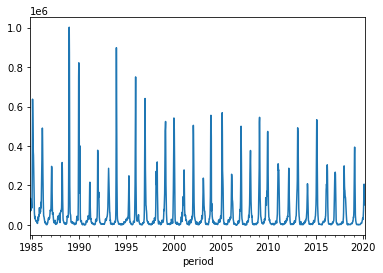

In [7]:
sorted_data['inc'].plot()

## Questions et réponses

### Quelles ont été les épidémies les plus fortes ? 

Epidemics are calculated in yearly incidence not in added months so the problem is to find a convention to define and add up all the weekly incidences. Here is one way 

In [9]:
first_august_week = [pd.Period(pd.Timestamp(y, 8, 1), 'W')
                     for y in range(1985,
                                    sorted_data.index[-1].year)]

In [10]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1],
                        first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

<AxesSubplot:>

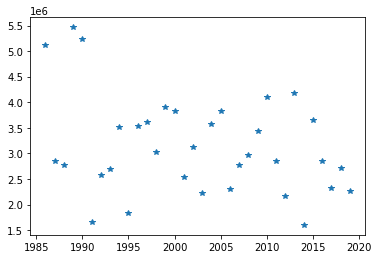

In [11]:
yearly_incidence.plot(style="*")

### Quelle est la distribution des épidémies? 